In [ ]:
!wget -q http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

In [ ]:
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null; echo " done."

 done.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models,layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
import os

In [ ]:
df = pd.read_pickle("/content/lrg.csv")
df.head()

,fn,cat,cat_id,bb_coords
0,000012.jpg,car,7,"[96, 155, 269, 350]"
1,000017.jpg,horse,13,"[77, 89, 335, 402]"
2,000023.jpg,person,15,"[1, 2, 461, 242]"
3,000026.jpg,car,7,"[124, 89, 211, 336]"
4,000032.jpg,aeroplane,1,"[77, 103, 182, 374]"


In [ ]:
sorted(df.cat_id.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
df.cat_id = df.cat_id-1
sorted(df.cat_id.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
main_folder = "/content/VOCdevkit/VOC2007/JPEGImages"

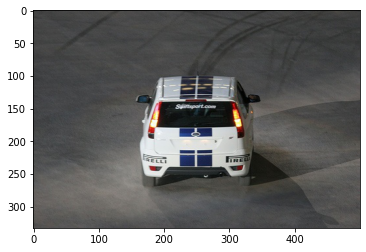

In [ ]:
imm = plt.imread(main_folder + "/" + df.fn[0])
plt.imshow(imm)
plt.show()

In [ ]:
df.bb_coords[0]

array([ 96, 155, 269, 350])

In [ ]:
imm.shape

(333, 500, 3)

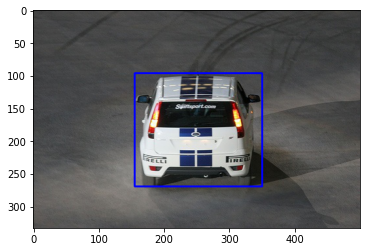

In [ ]:
import cv2
cv2.rectangle(imm,(155,96),(350,269),[0,0,255],2)
plt.imshow(imm)
plt.show()

In [ ]:
from imgaug import augmenters as ag
import imgaug as ig

In [ ]:
def augment(img,bb):
  aug1 = ag.Resize({"height": 150, "width": 150}).to_deterministic()
  bb_old = ig.BoundingBoxesOnImage([ig.BoundingBox(x1=bb[1],y1=bb[0],x2=bb[3],y2=bb[2])],shape=img.shape)
  img_ag = aug1.augment_images([img])[0]   # augementing the image to convert it into the shape of 150x150
  bb_ag = aug1.augment_bounding_boxes([bb_old])[0]  # augementing the bounding box to get bounding box corresonding to image of shape 150x150
  bb_out = [bb_ag.bounding_boxes[0].x1,bb_ag.bounding_boxes[0].y1,bb_ag.bounding_boxes[0].x2,bb_ag.bounding_boxes[0].y2]
  return img_ag,bb_out

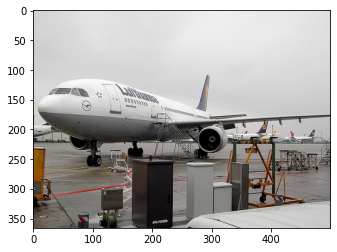

[106   8 262 498]


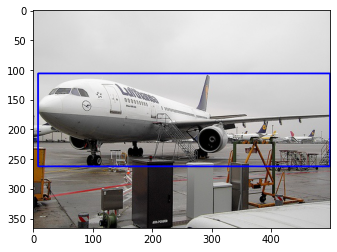

(366, 500, 3)


In [ ]:
#original 
img = plt.imread(main_folder + "/" + df.fn[5])
plt.imshow(img)
plt.show()
cord = df.bb_coords[5]
print(cord)
img2 = img.copy()
cv2.rectangle(img2,(cord[1],cord[0]),(cord[3],cord[2]),[0,0,255],2)
plt.imshow(img2)
plt.show()
print(img.shape)

(150, 150, 3)


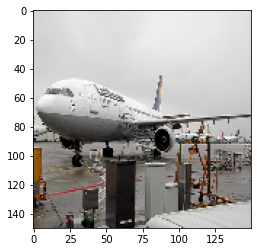

[2.4, 43.442623, 149.4, 107.37705]


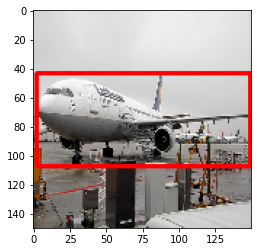

In [ ]:
img3,bb3 = augment(img,cord)
print(img3.shape)
plt.imshow(img3)
plt.show()
print(bb3)
cv2.rectangle(img3,(bb3[0],bb3[1]),(bb3[2],bb3[3]),[255,0,0],2)
plt.imshow(img3)
plt.show()

# Dataset preparation

In [ ]:
os.listdir(main_folder)[:5]

['001273.jpg', '008588.jpg', '006304.jpg', '008005.jpg', '003986.jpg']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fn         2501 non-null   object
 1   cat        2501 non-null   object
 2   cat_id     2501 non-null   int64 
 3   bb_coords  2501 non-null   object
dtypes: int64(1), object(3)
memory usage: 78.3+ KB


In [ ]:
x = [] # for all images
y1 = [] # for all categories
y2 = [] # for bounding boxes


for i in range(df.shape[0]):
  fpath = main_folder + "/" + df.fn[i]
  img = image.load_img(fpath)
  img = image.img_to_array(img)
  img,bb = augment(img,df.bb_coords[i])
  img = resnet50.preprocess_input(img)
  x.append(img)
  y1.append(df.cat_id[i])
  y2.append(bb)

In [ ]:
x = np.array(x)
y1 = to_categorical(y1)
y2 = np.array(y2)
print(x.shape)
print(y1.shape)
print(y2.shape)

(2501, 150, 150, 3)
(2501, 20)
(2501, 4)


# Buidling the CNN using Transfer Learning

In [ ]:
input_layer = layers.Input(shape=(150,150,3))

model = resnet50.ResNet50(include_top=False,weights='imagenet',input_tensor=input_layer)


for layer in model.layers[:-5]:
  layer.trainable=False


last_layer = model.layers[-1].output

# classification segment
out1 = layers.Flatten()(last_layer)
out1 = layers.Dropout(0.5)(out1)
out1 = layers.Dense(64,activation='relu')(out1)
out1 = layers.Dense(20,activation='softmax',name='classes')(out1)

# regression segment
out2 = layers.Flatten()(last_layer)
out2 = layers.Dropout(0.5)(out2)
out2 = layers.Dense(64,activation='relu')(out2)
out2 = layers.Dense(4,activation='relu',name='bb')(out2)

final_model = models.Model(inputs=input_layer,outputs=[out1,out2])

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
final_model.compile(optimizer='adam',metrics={"classes":"accuracy"},
                    loss={"bb":"mae","classes":"categorical_crossentropy"},
                    loss_weights={"bb":1,"classes":4})

In [ ]:
final_model.fit(x=x,y=[y1,y2],epochs=20,batch_size=64,shuffle=True,validation_split=0.2)

Epoch 1/20
32/32 [==============================] - 4s 117ms/step - loss: 36.8156 - classes_loss: 2.8144 - bb_loss: 25.5579 - classes_accuracy: 0.3245 - val_loss: 25.0580 - val_classes_loss: 1.6520 - val_bb_loss: 18.4502 - val_classes_accuracy: 0.4970
Epoch 2/20
32/32 [==============================] - 2s 76ms/step - loss: 19.6618 - classes_loss: 1.1005 - bb_loss: 15.2599 - classes_accuracy: 0.6540 - val_loss: 23.7384 - val_classes_loss: 1.5014 - val_bb_loss: 17.7327 - val_classes_accuracy: 0.6387
Epoch 3/20
32/32 [==============================] - 2s 76ms/step - loss: 15.0585 - classes_loss: 0.6338 - bb_loss: 12.5234 - classes_accuracy: 0.7970 - val_loss: 22.6726 - val_classes_loss: 1.3833 - val_bb_loss: 17.1393 - val_classes_accuracy: 0.6567
Epoch 4/20
32/32 [==============================] - 2s 76ms/step - loss: 12.8125 - classes_loss: 0.3695 - bb_loss: 11.3347 - classes_accuracy: 0.8625 - val_loss: 23.6799 - val_classes_loss: 1.4505 - val_bb_loss: 17.8778 - val_classes_accuracy: 0.

In [ ]:
!wget -q https://sarahelliottphotography.co.uk/wp-content/uploads/2017/01/autumn-childrens-shoot.jpg
!wget -q https://ak8.picdn.net/shutterstock/videos/30988048/thumb/1.jpg
!wget -q https://images-na.ssl-images-amazon.com/images/I/71PxS7WoODL._SX466_.jpg

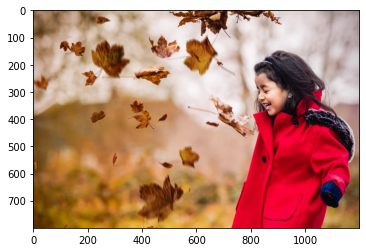

In [ ]:
img1 = plt.imread("autumn-childrens-shoot.jpg")
plt.imshow(img1)
plt.show()

In [ ]:
img1 = image.load_img("autumn-childrens-shoot.jpg",target_size=(150,150))
img1 = image.img_to_array(img1)
img1 = resnet50.preprocess_input(img1)
output = final_model.predict(img1.reshape(1,150,150,3))

In [ ]:
output

[array([[1.1310012e-13, 4.6727727e-10, 4.2284995e-07, 2.5744684e-14,
         1.6829791e-18, 8.0238397e-18, 3.3943959e-12, 6.2267247e-10,
         2.3889907e-22, 8.1410380e-16, 3.5797473e-10, 5.3679938e-19,
         3.5679161e-05, 5.3419722e-14, 9.9996388e-01, 7.5812878e-14,
         3.8696048e-13, 1.0239460e-09, 4.5650123e-19, 6.7579392e-17]],
       dtype=float32),
 array([[ 68.79944,  23.41321, 159.92418, 156.04572]], dtype=float32)]

In [ ]:
output_class = np.argmax(output[0])
output_class

14

In [ ]:
df.cat[df.cat_id==output_class].unique()

array(['person'], dtype=object)

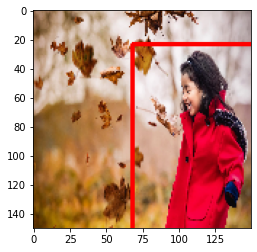

In [ ]:
img1 = image.load_img("autumn-childrens-shoot.jpg",target_size=(150,150))
img1 = image.img_to_array(img1).astype('int32')
cv2.rectangle(img1,(output[1][0][0],output[1][0][1]),(output[1][0][2],output[1][0][3]),[255,0,0],2)
plt.imshow(img1)
plt.show()

In [ ]:
output[1]

array([[ 41.541225,  25.547083,  87.887955, 134.4145  ]], dtype=float32)

In [ ]:
import datetime
start = datetime.datetime.now()
output = final_model.predict(img1.reshape(1,150,150,3))
stop = datetime.datetime.now()

In [ ]:
delta = stop-start

In [ ]:
delta.microseconds

42311